In [1]:
#general
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np

#machine learning 
from sklearn.linear_model import LogisticRegression  
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from statsmodels.tsa.arima.model import ARIMA

#helper functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

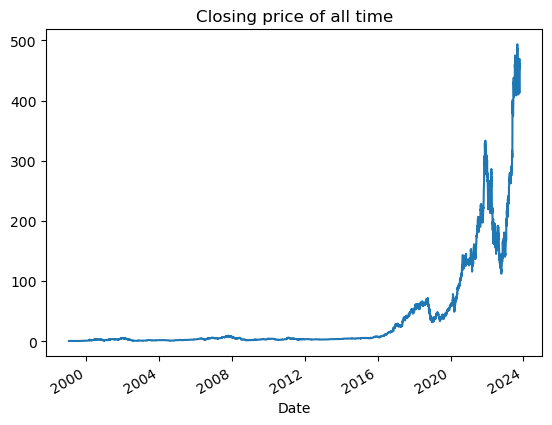

In [2]:
#getting a dataframe containing all pass NVDA stock prices 
nvda = yf.Ticker("NVDA")
nvda_df = nvda.history(period='max')
nvda_df['Close'].plot()
plt.title("Closing price of all time")
plt.show()
#upon plotting all historic data of NVDA, we see significanet change from
#2018 onwards, which is more relevant to the current context

In [3]:
#download NVDA stock data from 2017 to now
df = yf.download('NVDA', '2017-1-1', '2023-10-14')

[*********************100%%**********************]  1 of 1 completed


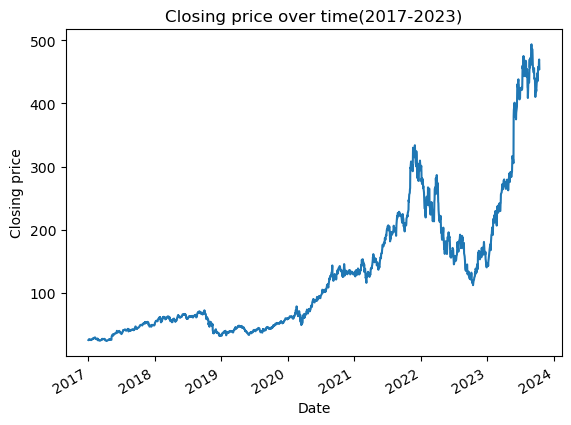

In [4]:
df['Close'].plot(use_index=True)
plt.ylabel("Closing price")
plt.title("Closing price over time(2017-2023)")
plt.show()

In [5]:
#preparation of data-----------------------------------------------------------------------------------------------

#to see how the closing price has changed from the day before
#1 indicating an increase while 0 indicates a decrease
df["Change"] = df["Close"] - df["Close"].shift(+1)
df["Change_yn"] = (df["Change"] > 0).astype(int)

#creating a function for simple moving average
def SMA(data, period, column):
    return data[column].rolling(window=period).mean()


df['SMA 5days'] = SMA(df, 5, 'Adj Close')
df['SMA 30days'] = SMA(df, 30, 'Adj Close')
df['SMA 50days'] = SMA(df, 50, 'Adj Close')
#remove the single nan value created from the shift
df = df.dropna()
df.isnull().sum().sum()


#standardising data 
Y = df['Change_yn']
X = df[['Open','High','Low','Close','Adj Close','Volume','SMA 5days','SMA 30days','SMA 50days']]
sc = StandardScaler()
X = sc.fit_transform(X)

#Standardised data to prevent outliers from influencing the model. Chosen to use StandardScalar as I take into account the volatility of the stock market and the possibility of extreme opening and closing values. 



In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2)

In [7]:
#From these 4 models, choose to focus on randomforest due to best accuracy score and lowest RMSE
models = [SVC,
          LogisticRegression,
          GaussianNB,
          RandomForestClassifier] 
           
accuracy = []
precision = []
recall = []
rmse = []
for m in models:
    model_ = m()
    model_.fit(X_train,Y_train)
    pred = model_.predict(X_test)
    acc = accuracy_score(Y_test,pred)
    prec = precision_score(Y_test,pred)
    rec = recall_score(Y_test,pred)
    mse = mean_squared_error(Y_test,pred)
    rmse.append(mse)
    accuracy.append(acc)
    precision.append(prec)
    recall.append(rec)
    print(f'RMSE of {m} is {rmse[-1]}')
    print(f'Accuracy of {m} is {accuracy[-1]}')
    print(f'Precision of {m} is {precision[-1]}')
    print(f'Recall score of {m} is {recall[-1]}')
    print("-------------------------------------")


RMSE of <class 'sklearn.svm._classes.SVC'> is 0.48493975903614456
Accuracy of <class 'sklearn.svm._classes.SVC'> is 0.5150602409638554
Precision of <class 'sklearn.svm._classes.SVC'> is 0.51875
Recall score of <class 'sklearn.svm._classes.SVC'> is 0.9595375722543352
-------------------------------------
RMSE of <class 'sklearn.linear_model._logistic.LogisticRegression'> is 0.33433734939759036
Accuracy of <class 'sklearn.linear_model._logistic.LogisticRegression'> is 0.6656626506024096
Precision of <class 'sklearn.linear_model._logistic.LogisticRegression'> is 0.6131386861313869
Recall score of <class 'sklearn.linear_model._logistic.LogisticRegression'> is 0.9710982658959537
-------------------------------------
RMSE of <class 'sklearn.naive_bayes.GaussianNB'> is 0.45180722891566266
Accuracy of <class 'sklearn.naive_bayes.GaussianNB'> is 0.5481927710843374
Precision of <class 'sklearn.naive_bayes.GaussianNB'> is 0.5403508771929825
Recall score of <class 'sklearn.naive_bayes.GaussianNB'>

In [8]:
#Conduct k-fold cross validation to ensure that scores of the model do not depend on the picked training and test set
kf = KFold(n_splits = 5)
models = [RandomForestClassifier, SVC]
for m in models:
    model_ = m()
    scores = cross_val_score(model_, X_train, Y_train, cv=kf)
    print(scores)

[0.65789474 0.63018868 0.64150943 0.64150943 0.65660377]
[0.54511278 0.52830189 0.5509434  0.53962264 0.58113208]


In [9]:
#checking the importance of each individual feature 
rf = RandomForestClassifier()
rf.fit(X_train,Y_train)
predictors = ['Open','High','Low','Close','Adj Close','Volume','SMA 5days','SMA 30days','SMA 50days']
importancedf = pd.DataFrame({'features': predictors, 'importance':rf.feature_importances_})
importancedf

,features,importance
0,Open,0.134552
1,High,0.087629
2,Low,0.087175
3,Close,0.131155
4,Adj Close,0.134520
5,Volume,0.115732
6,SMA 5days,0.118948
7,SMA 30days,0.098662
8,SMA 50days,0.091628


In [10]:
#creating training and test data for ARIMA model 
df_arima = df
df_close = df['Close']
arima_train = df_arima['Close'][:round(len(df_arima["Close"])*0.8)]
arima_test = df_arima['Close'][round(len(df_arima["Close"])*0.2):]


fitted.predict(dynamic=False, start ='2023-02-14' )

<Figure size 640x480 with 0 Axes>

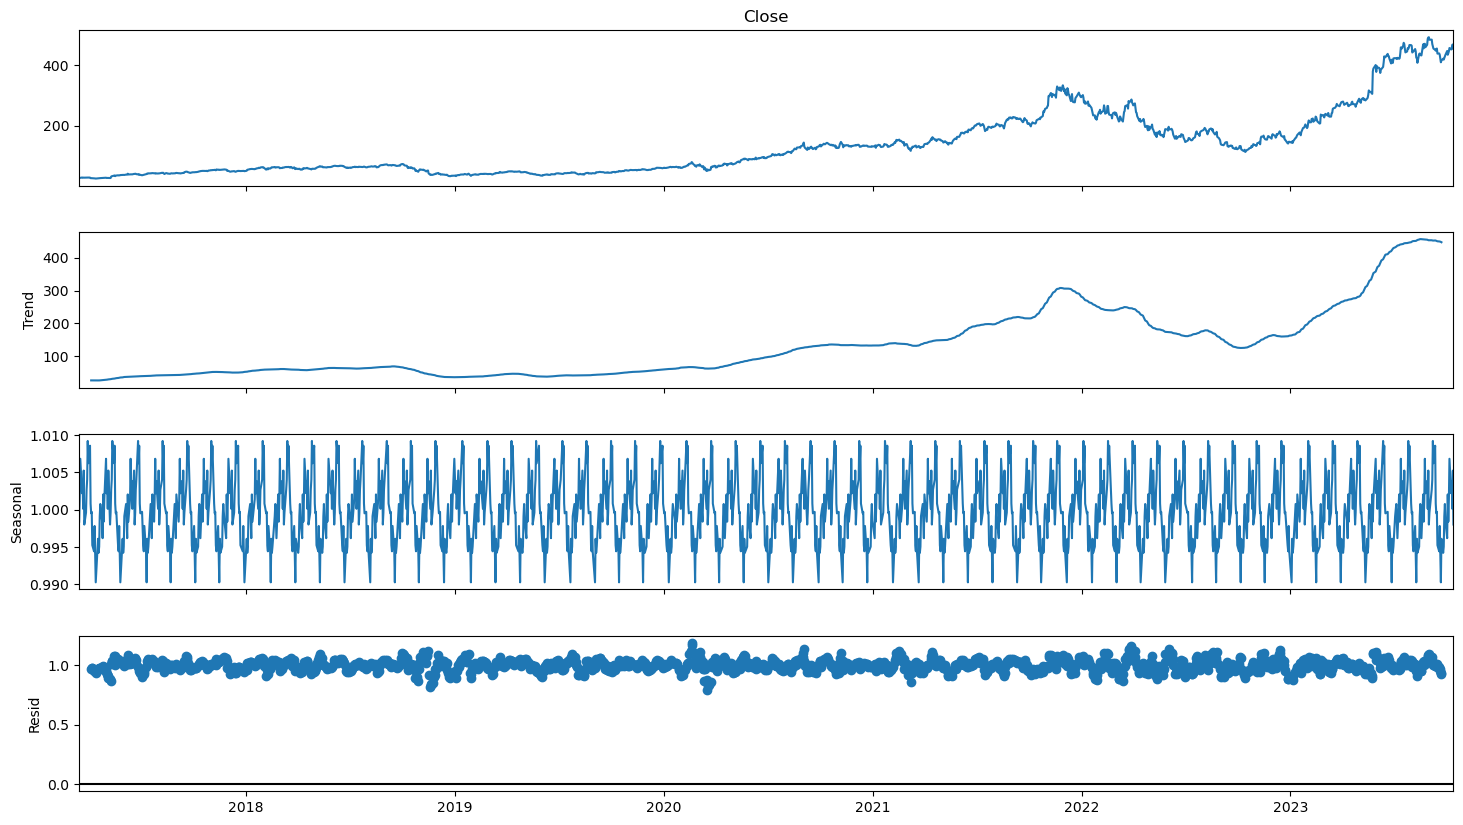

In [11]:
#Separate trend and seasonality from time series
result = seasonal_decompose(df_close, model='multiplicative', period=30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


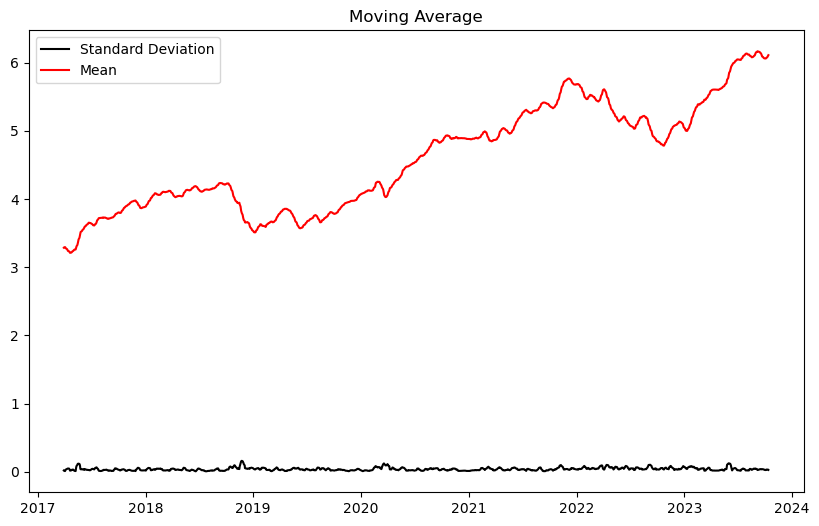

In [64]:
#visualise the changes in moving average, as well as standard deviation.

from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

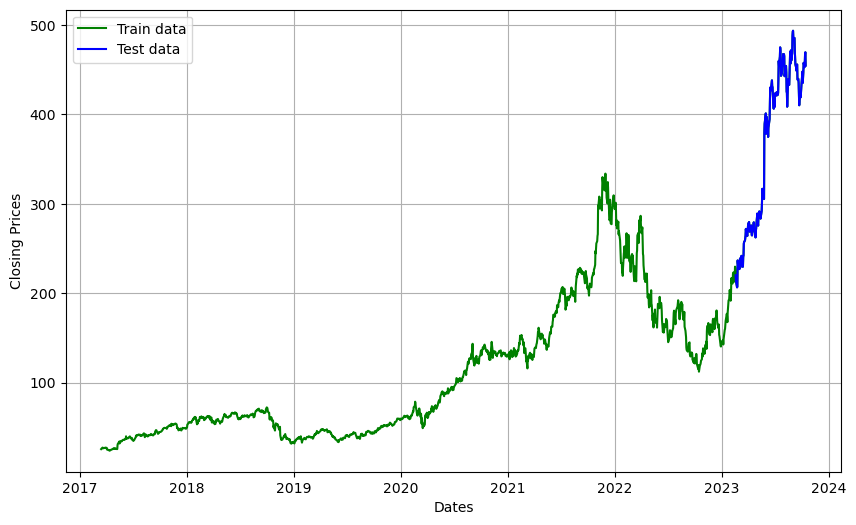

In [12]:
train_data, test_data = df_close[3:int(len(df_close)*0.9)], df_close[int(len(df_close)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_close, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()


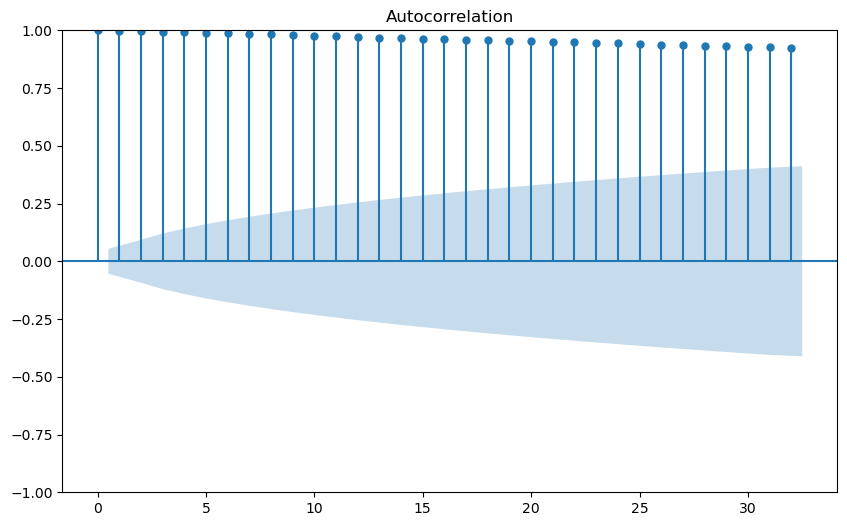

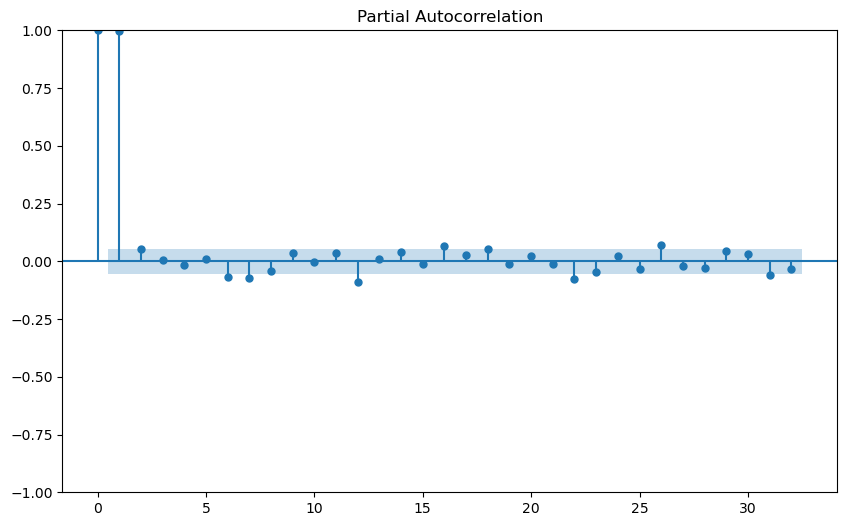

In [56]:
#time series of Random Walk is observed, so we can conclude that there is no stationarity in the time series
#given the need to transform the time series into one that is stationary, we will use the ARIMA model.  

#from acf graph, we can see high correlation with slow decay towards 0
#from the pcaf graph, we see a large spike at lag 1 and 2 before a "cut off" at lag2. Thus we will use an order of 2 for an AR(2) model.
#we shall use an ARIMA(2,d,0) model

acf_graph = plot_acf(arima_train)
pacf_graph = plot_pacf(arima_train)


<Axes: xlabel='Date'>

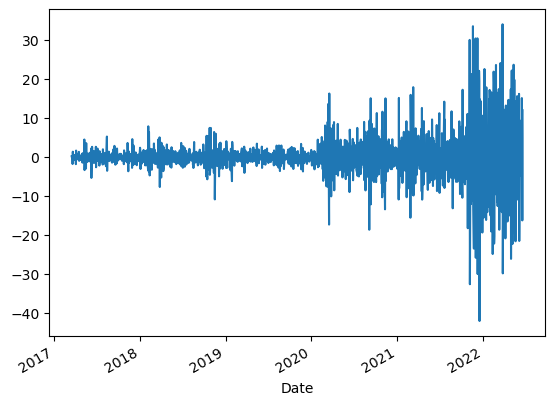

In [17]:
#trasnforming to startionary via differencing
t_arima_train = arima_train.diff().dropna()
t_arima_train2 = t_arima_train.diff().dropna() 
t_arima_train2.plot()

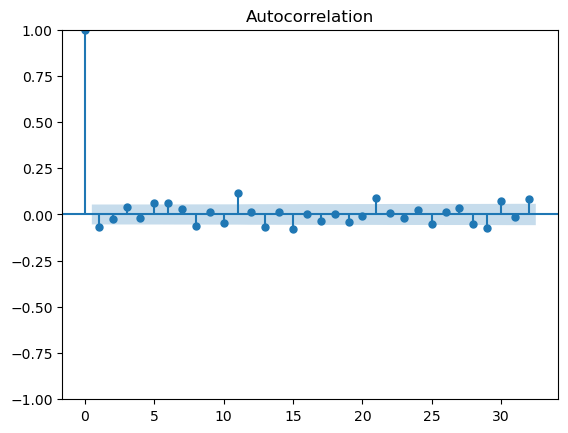

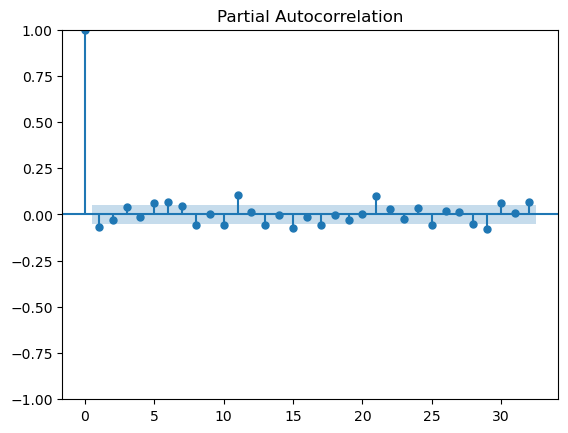

In [18]:
#for both acf and pacf of transformed data, high correlation is only observed at lag zero. Thus there is stationarity of the time series
t_acf_graph = plot_acf(t_arima_train)
t_pacf_graph = plot_pacf(t_arima_train)

#as only a single differencing is required to achieve stationarity in time series, we can conclude ARIMA(2,1,q) shall be used

In [107]:
#fitting our ARIMA Model based on the obtained orders
model = ARIMA(test_data, order=(2,1,0))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  166
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -628.830
Date:                Mon, 23 Oct 2023   AIC                           1263.661
Time:                        00:58:03   BIC                           1272.978
Sample:                             0   HQIC                          1267.443
                                - 166                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0092      0.088      0.105      0.917      -0.164       0.182
ar.L2          0.0028      0.091      0.030      0.976      -0.175       0.180
sigma2       119.6183      5.130     23.316      0.0

/Users/lionsee/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lionsee/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/lionsee/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [138]:
#Prediction from my fitted ARIMA model
results = fitted.predict(dynamic=False)
results = results[-10:]
results = results.rename({'predicted_mean': 'Close'}, axis='columns')
results = results.reset_index()
results = results.drop(columns=['Date'], axis='columns')
results.index.name='Index'

In [152]:
results.to_csv("kaggle_submission.csv", sep=',', index=True, encoding='utf-8')